### Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jayak\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

### Creating directories

In [2]:
os.makedirs('dataset')
os.makedirs('dataset/train')
os.makedirs('dataset/val')

### Splitting daataset

In [3]:
path='C:\\Users\\jayak\\Rice leaf disease'
splitfolders.ratio(path, output='dataset',  ratio=(0.8, 0.2))

Copying files: 119 files [00:00, 185.94 files/s]


### Data augmentation

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size =32
base_dir = 'dataset'
train_generator = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(base_dir+'/val',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 95 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


### Modelling

In [5]:
base_model =InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_norm

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
filepath = "C:\\Users\\jayak\\Rice leaf disease\\model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]
BATCH_SIZE = 8
STEPS_PER_EPOCH = 10
VALIDATION_STEPS = 64
MODEL_FILE = 'InceptionV3.h5'
history = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,callbacks=callbacks_list)
  
model.save(MODEL_FILE)

Epoch 1/10
10/10 [==============================] - 154s 15s/step - loss: 0.5644 - acc: 0.7918 - val_loss: 3.5371 - val_acc: 0.4167
Epoch 2/10
10/10 [==============================] - 142s 14s/step - loss: 0.2076 - acc: 0.9399 - val_loss: 6.0683 - val_acc: 0.3333
Epoch 3/10
10/10 [==============================] - 146s 15s/step - loss: 0.1586 - acc: 0.9495 - val_loss: 16.4542 - val_acc: 0.3333
Epoch 4/10
10/10 [==============================] - 147s 15s/step - loss: 0.0814 - acc: 0.9653 - val_loss: 5.6809 - val_acc: 0.3333
Epoch 5/10
10/10 [==============================] - 145s 14s/step - loss: 0.0316 - acc: 0.9937 - val_loss: 5.2204 - val_acc: 0.3333
Epoch 6/10
10/10 [==============================] - 149s 15s/step - loss: 0.0448 - acc: 0.9842 - val_loss: 8.2754 - val_acc: 0.3333
Epoch 7/10
10/10 [==============================] - 184s 18s/step - loss: 0.2033 - acc: 0.9464 - val_loss: 12.8864 - val_acc: 0.3333
Epoch 8/10
10/10 [==============================] - 184s 18s/step - loss: 

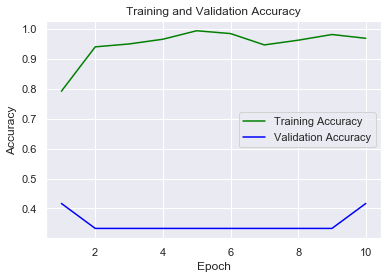

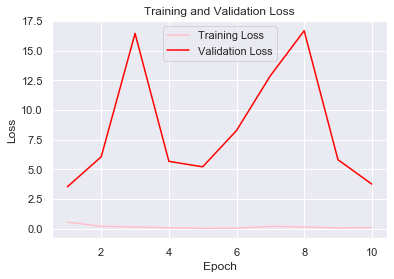

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
path=Path('C:\\Users\\jayak\\Rice leaf disease\\dataset\\val')

NameError: name 'Path' is not defined

In [ ]:
#shutil.rmtree('dataset')